---
title: Parameter Inference and Bootstrapping (from Spring 2025)
execute:
  echo: true
format:
  html:
    code-fold: true
    code-tools: true
    toc: true
    toc-title: Parameter Inference and Bootstrapping
    page-layout: full
    theme:
      - cosmo
      - cerulean
    callout-icon: false
jupyter:
  jupytext:
    text_representation:
      extension: .qmd
      format_name: quarto
      format_version: '1.0'
      jupytext_version: 1.16.1
  kernelspec:
    display_name: Python 3 (ipykernel)
    language: python
    name: python3
---

<!-- 
The **bias** of an estimator is how far off it is from the parameter, on average.

$$\begin{align}\text{Bias}(\hat{\theta}) = \mathbb{E}[\hat{\theta} - \theta] = \mathbb{E}[\hat{\theta}] - \theta\end{align}$$

For example, the bias of the sample mean as an estimator of the population mean is:

$$\begin{align}\mathbb{E}[\bar{X}_n - \mu]
&= \mathbb{E}[\frac{1}{n}\sum_{i=1}^n (X_i)] - \mu \\
&= \frac{1}{n}\sum_{i=1}^n \mathbb{E}[X_i] - \mu \\
&= \frac{1}{n} (n\mu) - \mu \\
&= 0\end{align}$$

Because its bias is equal to 0, the sample mean is said to be an **unbiased** estimator of the population mean.

The **variance** of an estimator is a measure of how much the estimator tends to vary from its mean value.

$$\begin{align}\text{Var}(\hat{\theta}) = \mathbb{E}\left[(\hat{\theta} - \mathbb{E}[\hat{\theta}])^2 \right]\end{align}$$

The **mean squared error** measures the "goodness" of an estimator by incorporating both the bias and variance. Formally, it is defined as:

$$\begin{align}\text{MSE}(\hat{\theta}) = \mathbb{E}\left[(\hat{\theta} - \theta)^2
\right]\end{align}$$ -->


::: {.callout-note collapse="false"}
## Learning Outcomes
* Construct confidence intervals for hypothesis testing using bootstrapping
* Understand the assumptions we make and their impact on our regression inference
* Explore ways to overcome issues of multicollinearity
* Compare regression correlation and causation
:::

Last time, we introduced the idea of random variables and how they affect the data and model we construct.
We also demonstrated the decomposition of model risk from a fitted model and dived into the bias-variance tradeoff.

In this lecture, we will explore regression inference via hypothesis testing, understand how to use bootstrapping under the right assumptions, and consider the environment of understanding causality in theory and in practice.


## Review: Bootstrap Resampling
### Example: Average Height of UC Berkeley Undegraduates
To determine the properties (e.g., variance) of the sampling distribution of an estimator, we’d need access to the population. Ideally, we'd want to consider all possible samples in the population, compute an estimate for each sample, and study the distribution of those estimates.

<p align="center">
<img src="images/population_samples.png" alt='y_hat' width='650'>
</p>

However, this can be quite expensive and time-consuming. Even more importantly, we don’t have access to the population 
— we only have ***one* random sample from the population**. How can we consider all possible samples if we only have one?

Bootstrapping comes in handy here! With bootstrapping, we treat our random sample as a "population" and resample from it *with replacement*. Intuitively, a random sample is representative of the population (if it is big enough), so **sampling from our sample** approximates **sampling from the population**. When sampling, there are a couple things to keep in mind:

* We need to sample the same way we constructed the original sample. Typically, this involves taking a simple random sample **with replacement**.
* New samples **must be the same size** as the original sample. We need to accurately model the variability of our estimates.

As Professor Grossman noted, we are essentially creating "parallel universes" via bootstrapping the sample.

::: {.callout-caution collapse="true"}
### Why must we resample *with replacement*?
Given an original sample of size $n$, we want a resample that has the same size $n$ as the original. Sampling *without* replacement will give us the original sample with shuffled rows. Hence, when we calculate summary statistics like the average, our sample *without* replacement will always have the same average as the original sample, defeating the purpose of a bootstrap.
:::

<p align="center">
<img src="images/bootstrap.png" alt='y_hat' width='700'>
</p>

Bootstrap resampling is a technique for estimating the sampling distribution of an estimator. 
Here are the steps of bootstrapping written out:

0. Assume that your random sample of size $n$ is representative of the true population.
1. To mimic a random draw of size $n$ from the true population, randomly resample $n$ observations **with replacement** from your random sample. Call this a "synthetic" random sample.
2. To compute a synthetic "best guess", calculate the sample statistic using your synthetic random sample. For example, you could calculate the sample average.
3. Repeat steps 1 and 2 many times. A common choice is 10,000 times.
4. The distribution of the 10,000 synthetic "best guesses" provide a sense of uncertainty around your original "best guess".

From here, we can construct a 95% confidence interval by taking the 2.5% and (100 - 2.5)% percentiles of our bootstrapped thetas.


How well does bootstrapping actually represent our population? The bootstrapped sampling distribution of an estimator does not exactly match the sampling distribution of that estimator, but it is often close. Similarly, the variance of the bootstrapped distribution is often close to the true variance of the estimator. The example below displays the results of different bootstraps from a *known* population using a sample size of $n=50$.

<p align="center">
<img src="images/bootstrapped_samples.png" alt='y_hat' width='600' height='700'>
</p>

In the real world, we don't know the population distribution. The center of the bootstrapped distribution is the estimator applied to our original sample, so we have no way of understanding the estimator's true expected value; the **center and spread of our bootstrap are *approximations***. The bootstrap **does not improve our estimate**. The quality of our bootstrapped distribution also depends on the quality of our original sample. If our original sample was not representative of the population (like Sample 5 in the image above), then the bootstrap is next to useless.

::: {.callout-note collapse="false"}
### Bootstrap limitations
In general, bootstrapping works better for *large samples*, when the population distribution is *not heavily skewed* (no outliers), and when the estimator is *“low variance”* (insensitive to extreme values).
:::


### Example: Bootstrapping a Regression Coefficient
To get a better idea of how bootstrapping works in practice, let's walk through a simple example of bootstrapping to estimate the relationship between miles per gallon and the weight of a vehicle. We observe this SLR model:
$$ 
\widehat{\text{mpg}} = \hat{\theta}_0 + \hat{\theta}_1 * \text{weight}
$$

Suppose we collected a sample of 20 cars from a population. For the purposes of this demo, we will assume that the `seaborn`'s `mpg` dataset represents the entire population. The following is a visualization of our sample:

In [1]:
#| code-fold: true
import numpy as np
import pandas as pd
import plotly.express as px
import sklearn.linear_model as lm
import seaborn as sns

np.random.seed(42)
sample_size = 100
mpg = sns.load_dataset('mpg')
print("Full Data Size:", len(mpg))
mpg_sample = mpg.sample(sample_size)
print("Sample Size:", len(mpg_sample))
px.scatter(mpg_sample, x='weight', y='mpg', trendline='ols', width=800)

Full Data Size: 398
Sample Size: 100


Fitting a linear model, we get an estimate of the slope $\hat{\theta}_1$:

In [2]:
#| code-fold: false
model = lm.LinearRegression().fit(mpg_sample[['weight']], mpg_sample['mpg'])
model.coef_[0] 

-0.007305965155512155

#### Bootstrap Implementation
We can use bootstrapping to estimate the distribution of that coefficient. Here we construct a bootstrap function that takes an estimator function and uses that function to construct many bootstrap estimates of the slope.

In [3]:
#| code-fold: false
def estimator(sample):
    """
    Fits an SLR to `sample` regressing mpg on weight, 
    and returns the slope of the fitted line
    """
    model = lm.LinearRegression().fit(sample[['weight']], sample['mpg'])
    return model.coef_[0]

The code below uses `df.sample` [(documentation)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) to generate a bootstrap sample that is the same size as the original sample.

In [4]:
#| code-fold: false
def bootstrap(sample, statistic, num_repetitions):
    """
    Returns the statistic computed on a num_repetitions  
    bootstrap samples from sample.
    """
    stats = []
    for i in np.arange(num_repetitions):
        # Step 1: Resample with replacement from our original sample to generate
        # a synthetic sample of the same size
        bootstrap_sample = sample.sample(frac=1, replace=True)
        
        # Step 2: Calculate a synthetic estimate using the synthetic sample
        bootstrap_stat = statistic(bootstrap_sample)
        
        # Append the synthetic estimate to the list of estimates
        stats.append(bootstrap_stat)
    return stats   

After constructing many bootstrap slope estimates (in this case, 10,000), we can visualize the distribution of these estimates.

In [5]:
#| code-fold: true
#Construct 10,000 bootstrap slope estimates
bs_thetas = bootstrap(mpg_sample, estimator, 10000)

#Visualize the distribution of these estimates
px.histogram(bs_thetas, title='Bootstrap Distribution of the Slope', 
             width=800)

#### Computing a Bootstrap CI
We can now compute the confidence interval for the slopes using the percentiles of the empirical distribution. Here, we are looking for a 95% confidence interval, so we want values at the 2.5 and 97.5 percentiles of the bootstrap samples to be the bounds of our interval. To find the interval, we can use the function defined below.

In [6]:
#| code-fold: true
def bootstrap_ci(bootstrap_samples, confidence_level=95):
    """
    Returns the confidence interval for the bootstrap samples.
    """
    lower_percentile = (100 - confidence_level) / 2
    upper_percentile = 100 - lower_percentile
    return np.percentile(bootstrap_samples, [lower_percentile, upper_percentile])
print(bootstrap_ci(bs_thetas))

[-0.00814752 -0.00653232]


#### Comparing to the Population CIs
In practice, you don't have access to the population. In this example, we took a sample from a larger dataset that we can treat as the population. Let's compare our results to what they would be if we had resampled from the larger dataset. Here is the 95% confidence interval for the slope when sampling 10,000 times from the entire dataset:

In [7]:
#| code-fold: true
mpg_pop = sns.load_dataset('mpg')
theta_est = [estimator(mpg_pop.sample(20)) for i in range(10000)]
print(bootstrap_ci(theta_est))

[-0.01019291 -0.00573015]


Visualizing the two distributions:

In [8]:
#| code-fold: true
thetas = pd.DataFrame({"bs_thetas": bs_thetas, "thetas": theta_est})
px.histogram(thetas.melt(), x='value', facet_row='variable', 
             title='Distribution of the Slope', width=800)

Although our bootstrapped sample distribution does not exactly match the sampling distribution of the population, we can see that it is relatively close. This demonstrates the benefit of bootstrapping — without knowing the actual population distribution, we can still roughly approximate the true slope for the model by using only a single random sample of 20 cars.


<!-- #### PurpleAir (chose to skip this section because it's too complex for the amount of pedagogical value it adds)
To show an example of this hypothesis testing process, we'll work with air quality measurement data. There are 2 common sources of air quality information: Air Quality System (AQS) and [PurpleAir sensors](https://www2.purpleair.com/). AQS is seen as the gold standard because it is high quality, well-calibrated, and publicly available. However, it is very expensive, and the sensors are far apart; reports are also delayed due to extensive calibration.  

On the other hand, PurpleAir (PA) sensors are much cheaper, easier to install, and has denser coverage (measurements are taken every 2 minutes). Unfortunately, its measurements are much less accurate than AQS. 

For this demo, our goal is to use AQS sensor measurements to improve PurpleAir measurements by training a model that adjusts PA measurements based on AQS measurements

$$PA \approx \theta_0 + \theta_1 AQS$$

Using this approximation, we'll invert the model to predict the true air quality from PA measurements
$$ \text{True Air Quality } \approx -\frac{\theta_0}{\theta_1} + \frac{1}{\theta_1} PA$$

::: {.callout-tip collapse="false"}
### Inverse Model Derivation 
Intuitively, AQS measurements are very accurate, so we can treat AQS as the true air quality: 
$AQS = \text{True Air Quality}$

$$
\begin{align}
PA &\approx \theta_0 + \theta_1 AQS \\
&\approx \theta_0 + \theta_1 \text{True Air Quality} \\
PA - \theta_0 &\approx + \theta_1 \text{True Air Quality} \\
\frac{PA - \theta_0}{\theta_1} &\approx \text{True Air Quality} \\
\text{True Air Quality } &\approx -\frac{\theta_0}{\theta_1} + \frac{1}{\theta_1} PA 
\end{align}
$$
:::

#| code-fold: true
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as lm
from sklearn.linear_model import LinearRegression

# big font helper
def adjust_fontsize(size=None):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    if size != None:
        SMALL_SIZE = MEDIUM_SIZE = BIGGER_SIZE = size

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.style.use('fivethirtyeight')
sns.set_context("talk")
sns.set_theme()
#plt.style.use('default') # revert style to default mpl
adjust_fontsize(size=20)
%matplotlib inline
csv_file = 'data/Full24hrdataset.csv'
usecols = ['Date', 'ID', 'region', 'PM25FM', 'PM25cf1', 'TempC', 'RH', 'Dewpoint']
full_df = (pd.read_csv(csv_file, usecols=usecols, parse_dates=['Date'])
        .dropna())
full_df.columns = ['date', 'id', 'region', 'pm25aqs', 'pm25pa', 'temp', 'rh', 'dew']
full_df = full_df.loc[(full_df['pm25aqs'] < 50)]


bad_dates = ['2019-08-21', '2019-08-22', '2019-09-24']
GA = full_df.loc[(full_df['id'] == 'GA1') & (~full_df['date'].isin(bad_dates)) , :]
AQS, PA = GA[['pm25aqs']], GA['pm25pa']
AQS.head()
pd.DataFrame(PA).head()
-->

## Prediction vs Inference

<!-- ### Correlation vs. Causation
Let us consider some questions in an arbitrary regression problem. 

What does $\theta_{j}$ mean in our regression?

* Holding other variables fixed, how much should our prediction change with $X_{j}$?

For simple linear regression, this boils down to the correlation coefficient

* Does having more $x$ predict more $y$ (and by how much)? -->

The difference between prediction vs inference is best illustrated through examples. 

1. **Prediction**: using our model to make **accurate predictions** about unseen data. Goal: get $\hat{Y}$ close to $Y$.
    - How much will the stock market go up tomorrow?
    - Is this credit card charge fraudulent?
    - Can my phone accurately detect my face?

2. **Inference**: using our model to **study underlying relationships** between our features and response. Goal: how and why does $X$ relate to $Y$?
    - What is the *effect* of getting a college degree on life outcomes?
    - What is the *effect* of a drug?
    - How does raising the minimum wage *affect* the unemployment rate?

There can be overlap between prediction and inference problems, too.
For example, a credit card agency builds a model to accurately **predict** credit scores. A customer might want to know **why** their credit score is lower than expected.

Inference is closely associated with both correlation and causality.

- **Correlational inference**
    - Are homes with granite countertops worth more money?
    - Do people with college degrees have higher lifetime earning?
    - Are people who smoke more likely to get cancer?
- **Causal inference** (harder!)
    - How much do granite countertops *raise* the value of a house?
    - Does getting a college degree *increase* lifetime earnings?
    - Does smoking *cause* cancer?

Questions about **causality** are about the **effects** of **interventions** (not just passive observation).

Note, however, that regression coefficients are sometimes called “effects”, which can be deceptive!

::: {.callout-tip collapse="false"}

When using data alone, **predictive questions** (i.e., are breastfed babies healthier?) can be answered, but **causal questions** (i.e., does breastfeeding improve babies’ health?) cannot. The reason for this is that there are many possible causes for our predictive question. For example, possible explanations for why breastfed babies are healthier on average include:

* **Causal effect:** breastfeeding makes babies healthier
* **Reverse causality:** healthier babies more likely to successfully breastfeed
* **Common cause:** healthier / richer parents have healthier babies and are more likely to breastfeed

We cannot tell which explanations are true (or to what extent) just by observing ($x$,$y$) pairs. Additionally, causal questions implicitly involve **counterfactuals**, events that didn't happen. 

:::

## Regression Inference

Let's solve correlational inference problem as a regression task.
Suppose we have a dataset of lifetime earnings and college degree status.

The correlational relationship between earnings and degrees can be written as a regression:
$$
\widehat{\text{Earnings}} = \hat{\theta}_0 + \hat{\theta}_1 (\text{Has college degree})
$$

- $\hat{\theta}_0$: What are the predicted lifetime earnings for someone **without** a college degree?
- $\hat{\theta}_1$: How much higher are predicted earnings for someone **with** a degree, *relative* to someone without a degree?

As it turns out, $\hat{\theta}_1 >> 0$. Do we now have strong evidence that getting a college degree increases lifetime earnings? **No.**

People with college degrees may just be more likely to have other traits that increase lifetime earnings, like family wealth.

- There could be other **observed** confounders, like health, demographics, and geography.
- There could also be **unobserved** confounders, like intrinsic motivation and values. We cannot be certain we've isolated the causal effect!

::: {.callout-note collapse="false"}

### Confounding factor
Let T represent a treatment (for example, alcohol use) and Y represent an outcome (for example, lung cancer).

<img src="images/confounder.png" alt='confounder' width='600'>

A **confounder** is a variable that affects both T and Y, distorting the correlation between them. Using the example above, rich parents could be a confounder for breastfeeding and a baby's health. Confounders can be a measured covariate (a feature) or an unmeasured variable we don’t know about, and they generally cause problems, as the relationship between T and Y is affected by data we cannot see. We commonly *assume that all confounders are observed and adjusted for* (this is also called **ignorability**).

:::

## Collinearity

Adding new terms to a regularized model often improves *predictive* performance.

So, as long as we're at it, let's add another variable to our lifetime earnings regression:
$$
\widehat{\text{Earnings}} = \hat{\theta}_0 + \hat{\theta}_1 (\text{Has college degree}) + \hat{\theta}_2 (\text{Family wealth in dollars}) +  \hat{\theta}_3 (\text{Has lived in a college town})
$$

Is adding this term appropriate if we want to make *inferences* about $\hat{\theta}_1$? **Probably not.**

- Having a college degree and living in a college town are **very highly correlated** features. To the regression model, these features look very similar!

- The regression model does not know that a college degree is more likely to change earnings than living in a college town. This is causal domain knowledge.

- The fitting process of OLS minimizes RMSE (i.e., it maximizes predictive performance).

- Because degree-status and living in a college town tend to have the same value, we could increase $\hat{\theta}_1$ by $\$X$ and decrease $\hat{\theta}_3$ by $\$X$ without changing the RMSE all that much.

- So, the $\hat{\theta}_1$ and $\hat{\theta}_3$ coefficients will be sensitive to the training data (i.e., high variance).

- This high variance does not harm *predictive* performance, but it does harm the *validity* of $\hat{\theta}_1$ as a measure of the association between college degrees and lifetime earnings.

In general, if you want to make inferences about a parameter, don't include features that are highly correlated with that parameter's feature.

## [Bonus Content]

### How to perform causal inference?

In a **randomized experiment**, participants are randomly assigned into two groups: treatment and control. A treatment is applied *only* to the treatment group. We assume ignorability and gather as many measurements as possible so that we can compare them between the control and treatment groups to determine whether or not the treatment has a true effect or is just a confounding factor. 

<img src="images/experiment.png" alt='experiment' width='600'>

However, often, randomly assigning treatments is impractical or unethical. For example, assigning a treatment of cigarettes to test the effect of smoking on the lungs would not only be impractical but also unethical.

An alternative to bypass this issue is to utilize **observational studies**. This can be done by obtaining two participant groups separated based on some identified treatment variable. Unlike randomized experiments, however, we cannot assume ignorability here: the participants could have separated into two groups based on other covariates! In addition, there could also be unmeasured confounders.

<img src="images/observational.png" alt='observational' width='600'>

<!-- ## Parameter Inference: Interpreting Regression Coefficients


Recall the framework we established in the last lecture. The relationship between datapoints is given by $Y = g(x) + \epsilon$, where $g(x)$ is the *true underlying relationship*, and $\epsilon$ represents randomness. If we assume $g(x)$ is linear, we can express this relationship in terms of the unknown, true model parameters $\theta$.

$$f_{\theta}(x) = g(x) + \epsilon = \theta_0 + \theta_1 x_1 + \ldots + \theta_p x_p + \epsilon$$

Our model attempts to estimate each **true** and **unobserved population parameter** $\theta_i$ using the sample estimates $\hat{\theta}_i$ calculated from the design matrix $\Bbb{X}$ and response vector $\Bbb{Y}$.

$$f_{\hat{\theta}}(x) = \hat{\theta}_0 + \hat{\theta}_1 x_1 + \ldots + \hat{\theta}_p x_p$$

Let's pause for a moment. At this point, we're very used to working with the idea of a model parameter. But what exactly does each coefficient $\theta_i$ actually *mean*? We can think of each $\theta_i$ as a *slope* of the linear model. If all other variables are held constant, a unit change in $x_i$ will result in a $\theta_i$ change in $f_{\theta}(x)$. Broadly speaking, a large value of $\theta_i$ means that the feature $x_i$ has a large effect on the response; conversely, a small value of $\theta_i$ means that $x_i$ has little effect on the response. In the extreme case, if the true parameter $\theta_i$ is 0, then the feature $x_i$ has **no effect** on $Y(x)$. 

If the true parameter $\theta_i$ for a particular feature is 0, this tells us something pretty significant about the world: there is no underlying relationship between $x_i$ and $Y(x)$! But how can we test if a parameter is actually 0? As a baseline, we go through our usual process of drawing a sample, using this data to fit a model, and computing an estimate $\hat{\theta}_i$. However, we also need to consider that if our random sample comes out differently, we may find a different result for $\hat{\theta}_i$. To infer if the **true parameter** $\theta_i$ is 0, we want to draw our conclusion from the distribution of $\hat{\theta}_i$ estimates we could have drawn across all other random samples. This is where [hypothesis testing](https://inferentialthinking.com/chapters/11/Testing_Hypotheses.html) comes in handy! 

To test if the true parameter $\theta_i$ is 0, we construct a **hypothesis test** where our **null hypothesis** states that the true parameter $\theta_i$ is 0, and the **alternative hypothesis** states that the true parameter $\theta_i$ is *not* 0. We can now use **confidence intervals to test the hypothesis**:

* Compute an approximate 95% confidence interval
* If the interval does not contain 0, reject the null hypothesis at the 5% level.
* Otherwise, data are consistent with null hypothesis (the true parameter *could* be 0).

<p align="center">
<img src="images/confidence_interval.png" alt='confidence_interval' width='650'>
</p>

For example, the 95% confidence interval shown above contains 0, so we cannot reject the null hypothesis. As a result, the true value of the population parameter $\theta$ could be 0. -->

### Hypothesis Testing Through Bootstrap

We looked at a simple example of bootstrapping earlier, but now, let's use bootstrapping to perform hypothesis testing. Recall that we use bootstrapping to compute approximate 95% confidence intervals for each $\theta_i$. If the interval doesn't contain 0, we reject the null hypothesis at the p=5% level. Otherwise, the data is consistent with the null, as the true parameter *could possibly* be 0.

To show an example of this hypothesis testing process, we'll work with the [snowy plover](https://www.audubon.org/field-guide/bird/snowy-plover) dataset throughout this section. The data are about the eggs and newly hatched chicks of the Snowy Plover. The data were collected at the Point Reyes National Seashore by a former [student at Berkeley](https://openlibrary.org/books/OL2038693M/BLSS_the_Berkeley_interactive_statistical_system). Here's a [parent bird and some eggs](http://cescos.fau.edu/jay/eps/articles/snowyplover.html).

<p align="center">
<img src="images/plover_eggs.jpg" alt='bvt' width='550'>
</p>

Note that `Egg Length` and `Egg Breadth` (widest diameter) are measured in millimeters, and `Egg Weight` and `Bird Weight` are measured in grams. For reference, a standard paper clip weighs about one gram.

In [9]:
#| code-fold: true
import pandas as pd
eggs = pd.read_csv("data/snowy_plover.csv")
eggs.head(5)

,egg_weight,egg_length,egg_breadth,bird_weight
0,7.4,28.80,21.84,5.2
1,7.7,29.04,22.45,5.4
2,7.9,29.36,22.48,5.6
3,7.5,30.10,21.71,5.3
4,8.3,30.17,22.75,5.9


Our goal will be to predict the weight of a newborn plover chick, which we assume follows the true relationship $Y = f_{\theta}(x)$ below.

$$\text{bird\_weight} = \theta_0 + \theta_1 \text{egg\_weight} + \theta_2 \text{egg\_length} + \theta_3 \text{egg\_breadth} + \epsilon$$

Note that for each $i$, the parameter $\theta_i$ is a fixed number, but it is unobservable. We can only estimate it. The random error $\epsilon$ is also unobservable, but it is assumed to have expectation 0 and be independent and identically distributed across eggs.

Say we wish to determine if the `egg_weight` impacts the `bird_weight` of a chick – we want to infer if $\theta_1$ is equal to 0.

First, we define our hypotheses:

* **Null hypothesis**: the true parameter $\theta_1$ is 0; any variation is due to random chance.
* **Alternative hypothesis**: the true parameter $\theta_1$ is not 0.

Next, we use our data to fit a model $\hat{Y} = f_{\hat{\theta}}(x)$ that approximates the relationship above. This gives us the **observed value** of $\hat{\theta}_1$ from our data.

In [10]:
#| code-fold: false
from sklearn.linear_model import LinearRegression
import numpy as np

X = eggs[["egg_weight", "egg_length", "egg_breadth"]]
Y = eggs["bird_weight"]

model = LinearRegression()
model.fit(X, Y)

# This gives an array containing the fitted model parameter estimates
thetas = model.coef_

# Put the parameter estimates in a nice table for viewing
display(pd.DataFrame(
  [model.intercept_] + list(model.coef_),
  columns=['theta_hat'],
  index=['intercept', 'egg_weight', 'egg_length', 'egg_breadth']
))

print("RMSE", np.mean((Y - model.predict(X)) ** 2))

,theta_hat
intercept,-4.605670
egg_weight,0.431229
egg_length,0.066570
egg_breadth,0.215914


RMSE 0.04547085380275775


Our single sample of data gives us the value of $\hat{\theta}_1=0.431$. To get a sense of how this estimate might vary if we were to draw different random samples, we will use [bootstrapping](https://inferentialthinking.com/chapters/13/2/Bootstrap.html?). As a refresher, to construct a bootstrap sample, we will draw a resample from the collected data that:

* Has the same sample size as the collected data
* Is drawn with replacement (this ensures that we don't draw the exact same sample every time!)

We draw a bootstrap sample, use this sample to fit a model, and record the result for $\hat{\theta}_1$ on this bootstrapped sample. We then repeat this process many times to generate a **bootstrapped empirical distribution** of $\hat{\theta}_1$. This gives us an estimate of what the true distribution of $\hat{\theta}_1$ across all possible samples might look like.

In [11]:
#| code-fold: false
# Set a random seed so you generate the same random sample as staff
# In the "real world", we wouldn't do this
import numpy as np
np.random.seed(1337)

# Set the sample size of each bootstrap sample
n = len(eggs)

# Create a list to store all the bootstrapped estimates
estimates = []

# Generate a bootstrap resample from `eggs` and find an estimate for theta_1 using this sample. 
# Repeat 10000 times.
for i in range(10000):
    # draw a bootstrap sample
    bootstrap_resample = eggs.sample(n, replace=True)
    X_bootstrap = bootstrap_resample[["egg_weight", "egg_length", "egg_breadth"]]
    Y_bootstrap = bootstrap_resample["bird_weight"]
    
    # use bootstrapped sample to fit a model
    bootstrap_model = LinearRegression()
    bootstrap_model.fit(X_bootstrap, Y_bootstrap)
    bootstrap_thetas = bootstrap_model.coef_
    
    # record the result for theta_1
    estimates.append(bootstrap_thetas[0])
    
# calculate the 95% confidence interval 
lower = np.percentile(estimates, 2.5, axis=0)
upper = np.percentile(estimates, 97.5, axis=0)
conf_interval = (lower, upper)
conf_interval

(-0.25864811956848743, 1.103424385420405)

Our bootstrapped 95% confidence interval for $\theta_1$ is $[-0.259, 1.103]$. Immediately, we can see that 0 *is* indeed contained in this interval – this means that we *cannot* conclude that $\theta_1$ is non-zero! More formally, we fail to reject the null hypothesis (that $\theta_1$ is 0) at a 5% cutoff. 

We can repeat this process to construct 95% confidence intervals for the other parameters of the model.

In [12]:
np.random.seed(1337)

theta_0_estimates = []
theta_1_estimates = []
theta_2_estimates = []
theta_3_estimates = []


for i in range(10000):
    bootstrap_resample = eggs.sample(n, replace=True)
    X_bootstrap = bootstrap_resample[["egg_weight", "egg_length", "egg_breadth"]]
    Y_bootstrap = bootstrap_resample["bird_weight"]
    
    bootstrap_model = LinearRegression()
    bootstrap_model.fit(X_bootstrap, Y_bootstrap)
    bootstrap_theta_0 = bootstrap_model.intercept_
    bootstrap_theta_1, bootstrap_theta_2, bootstrap_theta_3 = bootstrap_model.coef_
    
    theta_0_estimates.append(bootstrap_theta_0)
    theta_1_estimates.append(bootstrap_theta_1)
    theta_2_estimates.append(bootstrap_theta_2)
    theta_3_estimates.append(bootstrap_theta_3)
    
theta_0_lower, theta_0_upper = np.percentile(theta_0_estimates, 2.5), np.percentile(theta_0_estimates, 97.5)
theta_1_lower, theta_1_upper = np.percentile(theta_1_estimates, 2.5), np.percentile(theta_1_estimates, 97.5)
theta_2_lower, theta_2_upper = np.percentile(theta_2_estimates, 2.5), np.percentile(theta_2_estimates, 97.5)
theta_3_lower, theta_3_upper = np.percentile(theta_3_estimates, 2.5), np.percentile(theta_3_estimates, 97.5)

# Make a nice table to view results
pd.DataFrame({"lower":[theta_0_lower, theta_1_lower, theta_2_lower, theta_3_lower], "upper":[theta_0_upper, \
                theta_1_upper, theta_2_upper, theta_3_upper]}, index=["theta_0", "theta_1", "theta_2", "theta_3"])

,lower,upper
theta_0,-15.278542,5.161473
theta_1,-0.258648,1.103424
theta_2,-0.099138,0.208557
theta_3,-0.257141,0.758155


Something's off here. Notice that 0 is included in the 95% confidence interval for *every* parameter of the model. Using the interpretation we outlined above, this would suggest that we can't say for certain that *any* of the input variables impact the response variable! This makes it seem like our model can't make any predictions – and yet, each model we fit in our bootstrap experiment above could very much make predictions of $Y$. 

How can we explain this result? Think back to how we first interpreted the parameters of a linear model. We treated each $\theta_i$ as a slope, where a unit increase in $x_i$ leads to a $\theta_i$ increase in $Y$, **if all other variables are held constant**. It turns out that this last assumption is very important. If variables in our model are somehow related to one another, then it might not be possible to have a change in one of them while holding the others constant. This means that our interpretation framework is no longer valid! In the models we fit above, we incorporated `egg_length`, `egg_breadth`, and `egg_weight` as input variables. These variables are very likely related to one another – an egg with large `egg_length` and `egg_breadth` will likely be heavy in `egg_weight`. This means that the model parameters cannot be meaningfully interpreted as slopes. 

To support this conclusion, we can visualize the relationships between our feature variables. Notice the strong positive association between the features.

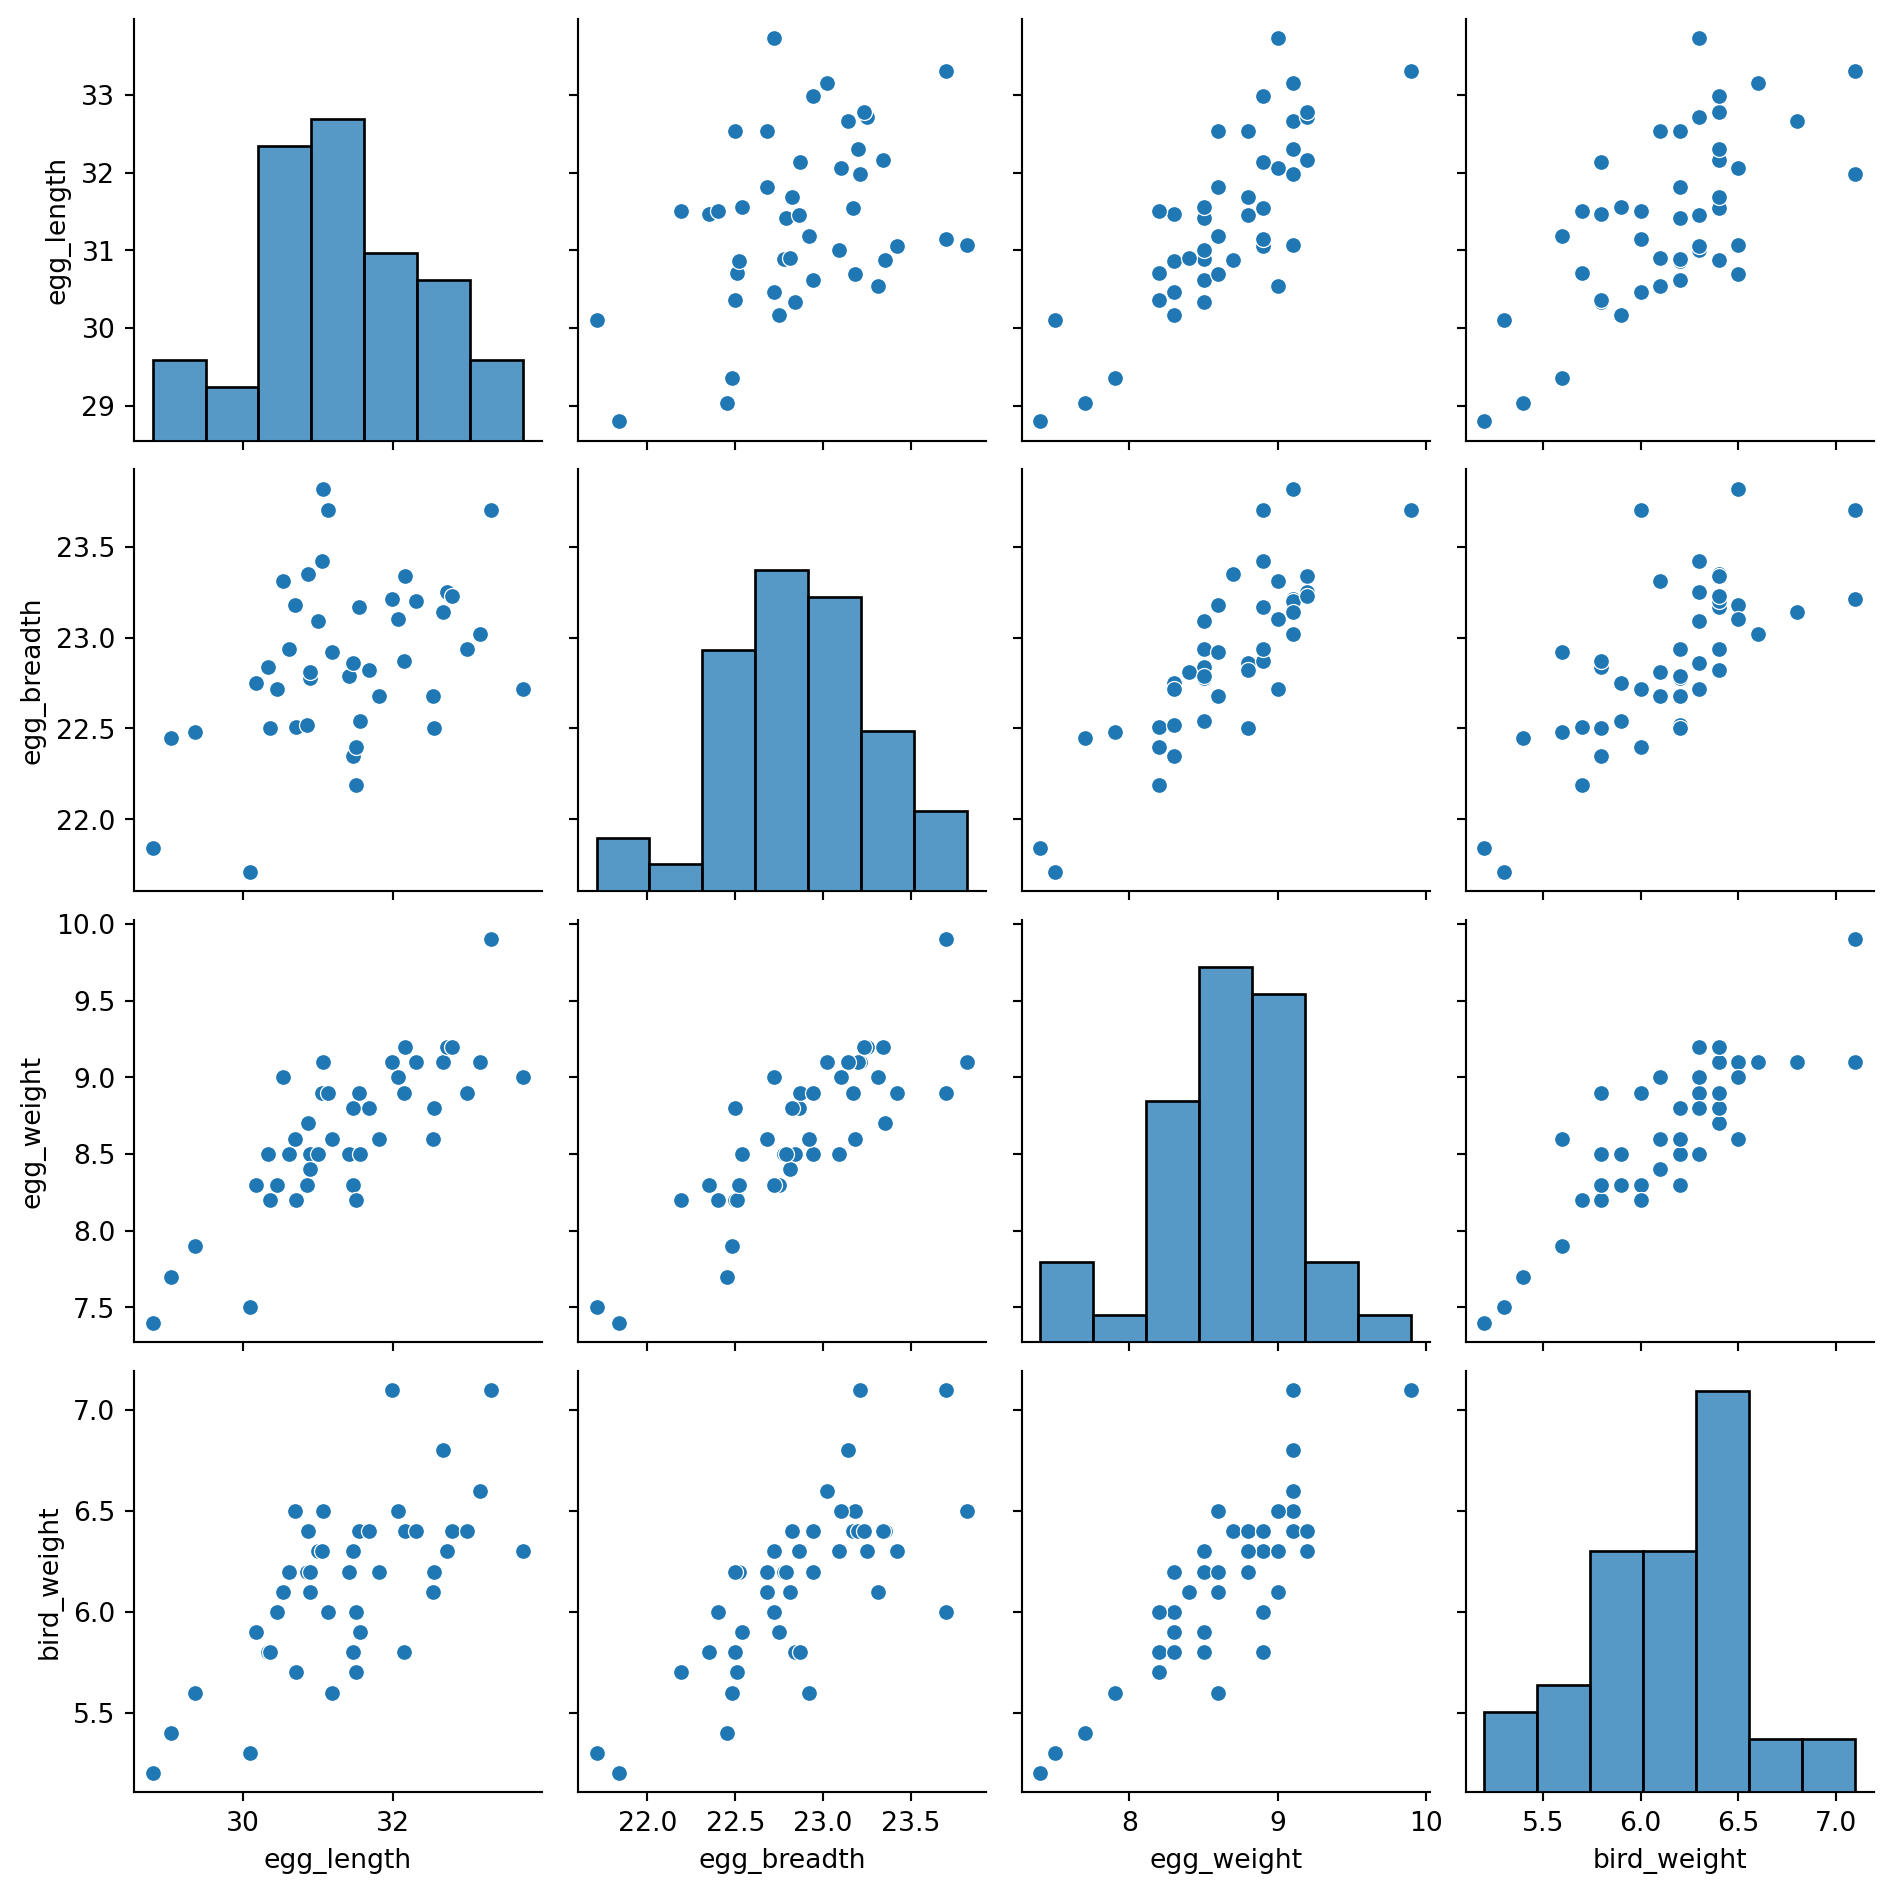

In [13]:
import seaborn as sns
sns.pairplot(eggs[["egg_length", "egg_breadth", "egg_weight", 'bird_weight']]);

This issue is known as **collinearity**, sometimes also called **multicollinearity**. Collinearity occurs when one feature can be predicted fairly accurately by a linear combination of the other features, which happens when one feature is highly correlated with the others. 

Why is collinearity a problem? Its consequences span several aspects of the modeling process:

* **Inference**: Slopes can't be interpreted for an inference task.
* **Model Variance**: If features strongly influence one another, even small changes in the sampled data can lead to large changes in the estimated slopes.
* **Unique Solution**: If one feature is a linear combination of the other features, the design matrix will not be full rank, and $\mathbb{X}^{\top}\mathbb{X}$ is not invertible. This means that least squares does not have a unique solution. See [this section](https://ds100.org/course-notes/ols/ols.html#uniqueness-of-the-ols-solution) of Course Note 12 for more on this.

The take-home point is that we need to be careful with what features we select for modeling. If two features likely encode similar information, it is often a good idea to choose only one of them as an input variable.

#### A Simpler Model

Let us now consider a more interpretable model: we instead assume a true relationship using only egg weight:

$$f_\theta(x) = \theta_0 + \theta_1 \text{egg\_weight} + \epsilon$$

In [14]:
from sklearn.linear_model import LinearRegression
X_int = eggs[["egg_weight"]]
Y_int = eggs["bird_weight"]

model_int = LinearRegression()

model_int.fit(X_int, Y_int)

# This gives an array containing the fitted model parameter estimates
thetas_int = model_int.coef_

# Put the parameter estimates in a nice table for viewing
pd.DataFrame({"theta_hat":[model_int.intercept_, thetas_int[0]]}, index=["theta_0", "theta_1"])

,theta_hat
theta_0,-0.058272
theta_1,0.718515


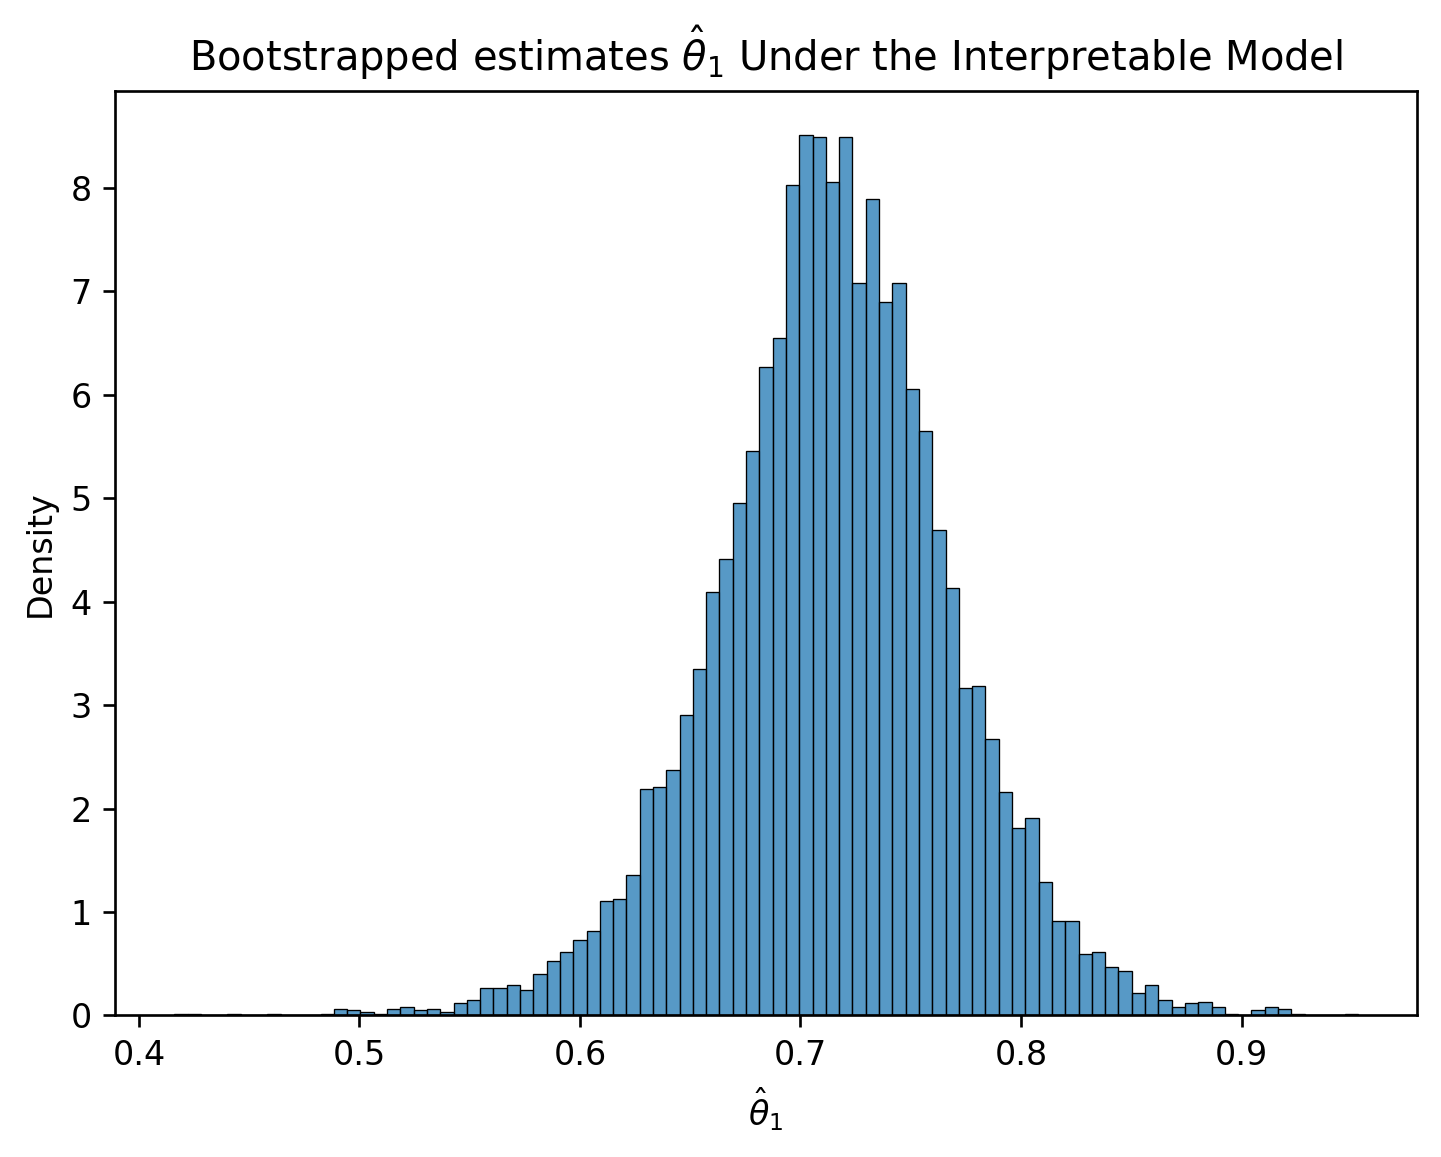

In [15]:
#| code-fold: true
import matplotlib.pyplot as plt

# Set a random seed so you generate the same random sample as staff
# In the "real world", we wouldn't do this
np.random.seed(1337)

# Set the sample size of each bootstrap sample
n = len(eggs)

# Create a list to store all the bootstrapped estimates
estimates_int = []

# Generate a bootstrap resample from `eggs` and find an estimate for theta_1 using this sample. 
# Repeat 10000 times.
for i in range(10000):
    bootstrap_resample_int = eggs.sample(n, replace=True)
    X_bootstrap_int = bootstrap_resample_int[["egg_weight"]]
    Y_bootstrap_int = bootstrap_resample_int["bird_weight"]
    
    bootstrap_model_int = LinearRegression()
    bootstrap_model_int.fit(X_bootstrap_int, Y_bootstrap_int)
    bootstrap_thetas_int = bootstrap_model_int.coef_
    
    estimates_int.append(bootstrap_thetas_int[0])

plt.figure(dpi=120)
sns.histplot(estimates_int, stat="density")
plt.xlabel(r"$\hat{\theta}_1$")
plt.title(r"Bootstrapped estimates $\hat{\theta}_1$ Under the Interpretable Model");

Notice how the interpretable model performs almost as well as our other model:

In [16]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(Y, model.predict(X))
rmse_int = mean_squared_error(Y_int, model_int.predict(X_int))
print(f'RMSE of Original Model: {rmse}')
print(f'RMSE of Interpretable Model: {rmse_int}')

RMSE of Original Model: 0.04547085380275775
RMSE of Interpretable Model: 0.046493941375556846


Yet, the confidence interval for the true parameter $\theta_{1}$ does not contain zero.

In [17]:
lower_int = np.percentile(estimates_int, 2.5)
upper_int = np.percentile(estimates_int, 97.5)

conf_interval_int = (lower_int, upper_int)
conf_interval_int

(0.6029335250209633, 0.8208401738546206)

In retrospect, it’s no surprise that the weight of an egg best predicts the weight of a newly-hatched chick.

A model with highly correlated variables prevents us from interpreting how the variables are related to the prediction.

<!-- #### Reminder: Assumptions Matter

Keep the following in mind:
All inference assumes that the regression model holds.

* If the model doesn’t hold, the inference might not be valid.
* If the [assumptions of the bootstrap](https://inferentialthinking.com/chapters/13/3/Confidence_Intervals.html?highlight=p%20value%20confidence%20interval#care-in-using-the-bootstrap-percentile-method) don’t hold…
    * Sample size n is large
    * Sample is representative of population distribution (drawn i.i.d., unbiased)
    
    …then the results of the bootstrap might not be valid.
 -->
